In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
import getopt
import yaml
from optics.algorithms import opticSiren
from optics.external.wcte import *
from optics.utils import list_config, get_config, load_config
from optics.models.siren import *
import h5py
import torch
import numpy as np
from tqdm import tqdm

In [24]:
def read_tof(filename):
    with h5py.File(filename,'r') as f:
        tof = torch.as_tensor(f['tof'][:])
    return tof

def read_pmtQ(filename):
    with h5py.File(filename,'r') as f:
        pmtQ = torch.as_tensor(f['pmtQ'][:])
    return pmtQ

# Beam data configs
vertex_momentum = 540
fname = 'muon_run2091.h5'
# evnet display to fit
pmtQ_data = read_pmtQ(fname)
nev = int(pmtQ_data.shape[0])
print('nev = ',nev)

tof_data = read_tof('muon_run2091_wTOF.h5')


# Brute force channel masking based on observed PMT hits
pmt_mask = torch.sum(pmtQ_data,axis=0)
pmt_mask[pmt_mask>0] = 1

nev =  23860


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   1.,   1.,   2.,   0.,   0.,   2.,   1.,   1.,   1.,
          1.,   0.,   1.,   4.,   3.,   3.,   3.,   4.,   3.,   6.,  10.,
          7.,  13.,   8.,   9.,  15.,  14.,  21.,  20.,  26.,  17.,  18.,
         24.,  33.,  33.,  34.,  42.,  67.,  53.,  64.,  71.,  84.,  78.,
         81., 140., 110., 113., 123., 139., 150., 192., 250., 312., 304.,
        289., 319., 314., 372., 410., 708., 462., 483., 516., 555., 596.,
        655., 822., 830., 663., 688., 621., 664., 637., 648., 945., 606.,
        584., 569., 546., 484., 485., 596., 504., 410., 360., 318., 307.,
        274., 233., 376., 213., 200., 186., 176., 131., 136., 161., 115.,
         81.,  89.,  86.,  73.,  48.,  56.,  72.,  30.,  43.,  29.,  34.,
         37.,  23.,  23.,  23.,  17.,  15.,   7.,   9.,  11.,  14.,   8.,
          6.,   6.,   6.,   3.,   1., 

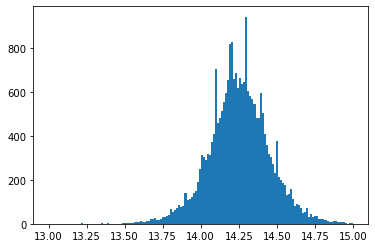

In [29]:
plt.hist(tof_data,bins=150,range=[13,15])

In [4]:
"""
Input normalization for Cherenkov Siren
"""
def momentum_normalization(val):
    return (val-525)/475

def distance_normalization(val):
    return (val-3000)/3000

def costh_normalization(val):
    return val

"""
Conversion from Cherenkov emission angle to OpticSiren angular input
"""
def get_direction(dir,costh,nphi):
    #dir = torch.tensor(dir, dtype=torch.float32)  # Ensure tensor input
    xx, yy, zz = dir ** 2

    # Compute dirx efficiently
    if xx < yy and xx < zz:
        inv_norm = 1.0 / torch.sqrt(zz + yy)
        dirx = torch.tensor([0, dir[2] * inv_norm, -dir[1] * inv_norm])
    elif yy < zz:
        inv_norm = 1.0 / torch.sqrt(xx + zz)
        dirx = torch.tensor([-dir[2] * inv_norm, 0, dir[0] * inv_norm])
    else:
        inv_norm = 1.0 / torch.sqrt(xx + yy)
        dirx = torch.tensor([dir[1] * inv_norm, -dir[0] * inv_norm, 0])

    # Compute diry using torch.cross for efficiency
    diry = torch.linalg.cross(dir, dirx)

    # Ensure costh is a 1D tensor
    # costh = torch.as_tensor(costh, dtype=torch.float32)

    # Precompute sin(theta) for efficiency
    sin_theta = torch.sqrt(1 - costh ** 2)

    # Generate sample_phi values (avoiding unnecessary reshaping)
    sample_phi = torch.linspace(0, 2 * np.pi - 2 * np.pi / nphi, nphi)

    # Compute sin and cos of sample_phi
    cos_phi, sin_phi = torch.cos(sample_phi), torch.sin(sample_phi)

    # Compute sample_dir using efficient broadcasting
    sample_dir = (
        costh[:, None, None] * dir +  # Expand costh along the required dimensions
        sin_theta[:, None, None] * (cos_phi[None, :, None] * dirx + sin_phi[None, :, None] * diry)
    )

    # Flatten sample_dir while keeping the last dimension intact
    sample_dir = sample_dir.reshape(-1, 3)

    # Compute angles efficiently
    dir_th = torch.acos(sample_dir[:, 2]) * (180 / np.pi)
    dir_phi = torch.atan2(sample_dir[:, 1], sample_dir[:, 0]) * (180 / np.pi)
    dir_phi[dir_phi<0] = dir_phi[dir_phi<0]+360

    return torch.stack((dir_phi, dir_th), dim=-1)

In [5]:
"""
Assumed parameters
"""
pmt_qe = 0.35 # not included in OpticSirn

# Load config
with open('./optics/config/forward_simulation.yaml','r') as f:
    cfg=yaml.safe_load(f)

device = cfg['device']['type'] 
if not torch.cuda.is_available():
    device = 'cpu'

# WCTE beam positions and directions
vertex_position = torch.tensor([0,1348.763,-424.7625], dtype=torch.float32)
vertex_direction = torch.tensor([0,-1,0], dtype=torch.float32)
vertex_direction_2d = [torch.atan2(vertex_direction[1],vertex_direction[0])*(180/np.pi),torch.acos(vertex_direction[2])*(180/np.pi)]
if vertex_direction_2d[0]<0:
    vertex_direction_2d[0] = vertex_direction_2d[0]+360

# Sampling along s
distance_step = 5 # step size
distance_min = 5
distance_max = 2795 # distance from beam pipe to mPMT on the other side
sample_distance = torch.tensor([(distance_min+distance_step*i) for i in range(int((distance_max-distance_min)/distance_step+1))], dtype=torch.float32)
sample_position = vertex_position[None,:]+ sample_distance[:,None]*vertex_direction[None,:]
sample_position = sample_position.reshape(-1, 3)

# Sampling along costh
costh_step = 0.025 # step size
costh_min = -0.975
costh_max = 0.975
costh = torch.tensor([(costh_min+costh_step*interval) for interval in range(int((costh_max-costh_min)/costh_step+1))], dtype=torch.float32)
nphi = 72 # number of azimuthal emission bins
sample_direction = get_direction(vertex_direction,costh,nphi)

# Convert to Cherenkov Siren inputs
cherenkov_siren_input = tuple( [torch.tensor([momentum_normalization(vertex_momentum)], dtype=torch.float32), distance_normalization(sample_distance),costh] )
cherenkov_siren_input = torch.stack(torch.meshgrid(*cherenkov_siren_input, indexing='ij'), dim=-1)
cherenkov_siren_input = cherenkov_siren_input.reshape(-1, 3)
cherenkov_siren_input[:, [1, 2]] = cherenkov_siren_input[:, [2, 1]]

# Load Cherenkov Siren
cprof_cfg = cfg['cprof']
cherenkov_siren = Siren(**cprof_cfg['network']).to(device)
cprof_file = cprof_cfg['file'] 
cherenkov_siren.load_state_dict(torch.load(cprof_file, map_location='cpu'))
cherenkov_siren.eval()

# Load Optic Siren model
model = opticSiren(cfg).to(device)
Qpred = []
Qtarg = []
loss = []
Qmax = float(cfg['data']['dataset']['Qmax'])
n_gamma_model = float(cfg['model']['n_gamma'])
npmt = int(cfg['data']['dataset']['npmt_max'])

# Efficiently generate index pairs
optic_siren_input_idx = torch.cartesian_prod(
    torch.arange(sample_position.shape[0]),
    torch.arange(sample_direction.shape[0])
)

# Generate input for Optic Siren
optic_siren_input_dir = sample_direction[optic_siren_input_idx[:,1], :2]  # Take first two columns
optic_siren_input_pos = sample_position[optic_siren_input_idx[:, 0], :3]  # Take first two columns

# Create Optic Siren response
npt = sample_position.shape[0]*sample_direction.shape[0]

nbatch = 100
batches = []
pred = []
batch_size = (int(npt*1./nbatch/nphi)+1)*nphi
# Run Optic Siren
print("Compute Optic Siren response")
with torch.no_grad():
    for b in tqdm(range(nbatch)):
        sel = slice(b*batch_size, (b+1)*batch_size)
        batch = {}
        batch['dirGamma'] = optic_siren_input_dir[sel]
        batch['posGamma'] = optic_siren_input_pos[sel]
        batch['nGamma'] = torch.ones((batch['dirGamma'].shape[0],), dtype=torch.float32)
        batch['weights'] = torch.ones((batch['dirGamma'].shape[0],npmt), dtype=torch.float32)
        batch['nGamma'] = batch['nGamma'].to(device)
        batch['posGamma'] = batch['posGamma'].to(device)
        batch['weights'] = batch['weights'].to(device)
        if 'dirGamma' in batch.keys():
            batch['dirGamma'] = batch['dirGamma'].to(device)
            train_input = {'nGamma': batch['nGamma'], 'posGamma': batch['posGamma'],'dirGamma': batch['dirGamma'], 'weights': batch['weights']}
        else:
            train_input = {'nGamma': batch['nGamma'], 'posGamma': batch['posGamma'],'weights': batch['weights']}
        out = model(train_input)
        pred_xform = out['Q'][:,:]
        if cfg['data']['dataset']['Q_normalizer'] == 'logNorm':
            eps = 0.1
            y0 = np.log10(eps)
            y1 = np.log10(Qmax + eps)
            pred_batch = (torch.pow(10., (pred_xform * (y1-y0) + y0))-eps)
        else:
            pred_batch = pred_xform
        # sum responses over phi directions
        pred_batch = pred_batch.view(-1, nphi, npmt)
        pred_batch = pred_batch.sum(dim=1)
        pred.append(pred_batch)

pred = torch.cat([data for data in pred])

[Siren] 3 in => 1 out, hidden 256 features 3 layers
        omega 30 first 30.0 hidden, the final layer linear True
[Siren] 5 in => 1843 out, hidden 512 features 5 layers
        omega 30 first 30.0 hidden, the final layer linear True
[OpticSiren] Loading checkpoint file data/optic_siren_v1.2.ckpt
[opticSiren] loading the state  data/optic_siren_v1.2.ckpt


/tmp/ipykernel_545/31547445.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cherenkov_siren.load_state_dict(torch.load(cprof_file, map_location='cpu'))
/eos/home-i01/k/

Compute Optic Siren response


100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


In [6]:
normalization_factor = 1000.
cherenkov_factor = normalization_factor*distance_step*costh_step

learning_rate = 1e-6
mom_reco = []
fit_loss = []

cherenkov_siren_input = cherenkov_siren_input.to(device)
loss_fn = torch.nn.MSELoss(reduction='sum')
cherenkov_siren_input[:,0] = 0
dummy_input = torch.zeros_like(cherenkov_siren_input, device=device)
dummy_input = dummy_input + torch.tensor([1.0], device=device)[None, :] * (torch.arange(dummy_input.shape[1], device=device) == 0)

In [7]:
# Fit a subset of events
for j in tqdm(range(0,100)):
    input_seed = momentum_normalization(vertex_momentum) # set a proper starting seed
    input_param = torch.nn.Parameter(torch.tensor([input_seed], device=device), requires_grad=True)
    optimizer = torch.optim.SGD([input_param], lr=1e-6)
    pmtQ_true = pmtQ_data[j]
    pmtQ_true_sum = torch.sum(pmtQ_true)
    if pmtQ_true_sum.item()<100:
        mom_reco.append(-1)
        fit_loss.append(-1)
        continue
    pmtQ_true = pmtQ_true.to(device)
    pmt_mask = pmt_mask.to(device)
    tolerance = 1e-4
    max_epochs = 1000
    prev_loss = float('inf')
    best_loss = float('inf')
    best_mom = None
    ref_scale = None
    for i in range(max_epochs):
        input_c = input_param[0]*dummy_input+cherenkov_siren_input
        cherenkov_siren_output = cherenkov_siren(input_c,clone=False)
        cherenkov_siren_output = cherenkov_siren_output*cherenkov_siren_output*cherenkov_factor #conversion to actual photon yield

        # Sum to get total charges per PMT
        optic_siren_input_ngamma = cherenkov_siren_output/nphi
        pmtQ_pred = optic_siren_input_ngamma*pred/n_gamma_model*pmt_qe
        pmtQ_pred = torch.sum(pmtQ_pred,dim=0)
        pmtQ_pred = pmtQ_pred*pmt_mask
        pmtQ_pred_sum = torch.sum(pmtQ_pred)
        
        # Set a reference charge scale since absolute charge scale is not calibrated
        if i==0:
            ref_scale = pmtQ_pred_sum.item()

        optimizer.zero_grad()
        # Shape-only loss
        loss = loss_fn(pmtQ_pred*ref_scale/pmtQ_pred_sum,pmtQ_true*ref_scale/pmtQ_true_sum) 
        
        # autograd
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_mom = input_param.item()  # Save best weights

        # Convergence check
        loss_diff = abs(prev_loss - loss.item())
        if loss_diff < tolerance:
            # print(f"Converged at epoch {i}")
            break

        prev_loss = loss.item()

    # Save results
    if best_mom>-1 and best_mom<1:
        vertex_momentum = 475*best_mom+525 
        mom_reco.append(vertex_momentum)
        fit_loss.append(best_loss)
    else:
        mom_reco.append(-1)
        fit_loss.append(-1)

print(len(mom_reco))
np.savez_compressed("result.npz",mom_reco=mom_reco,fit_loss=fit_loss)

100%|██████████| 100/100 [06:31<00:00,  3.92s/it]

100


14200 169.35800462961197 740.8886559307575


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        6.000e+00, 0.000e+00, 5.000e+00, 1.000e+01, 9.000e+00, 3.200e+01,
        4.100e+01, 1.300e+01, 1.000e+00, 1.900e+01, 9.900e+01, 8.200e+01,
        3.390e+02, 1.410e+02, 4.000e+01, 1.400e+01, 4.200e+01, 1.140e+02,
        1.250e+02, 1.140e+02, 1.770e+02, 1.360e+02, 5.300e+01, 2.800e+01,
        3.100e+01, 1.430e+02, 3.510e+02, 6.550e+02, 9.790e+02, 3.330e+02,
        3.200e+01, 3.450e+02, 9.210e+02, 1.262e+03, 1.485e+03, 5.320e+02,
        4.030e+02, 1.430e+02, 8.500e+01, 6.990e+02, 1.373e+03, 1.085e+03,
        4.890e+02, 8.300e+01, 1.310e+02, 2.950e+02, 2.600e+02, 1.190e+02,
        5.000e+01, 2.100e+01, 2.700e+01, 3.100e+01, 2.700e+01, 3.100e+01,
        1.600e+01, 1.000e+01, 5.000e+0

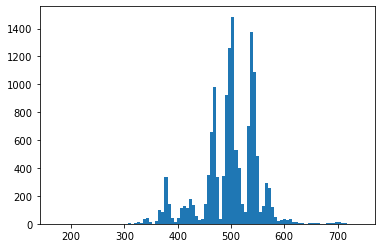

In [21]:
# visualize fit results
npz_file = np.load('muon_run2091.npz', allow_pickle=True)
mom_reco=npz_file['mom_reco']
fit_loss=npz_file['fit_loss']
print(len(mom_reco),np.min(mom_reco[mom_reco>-1]),np.max(mom_reco))
plt.hist(mom_reco,bins=100,range=[np.min(mom_reco[mom_reco>-1]),np.max(mom_reco)])

In [31]:
# Make event displays and loss surface scan

import os
geofile = cfg['detector']['geometry_definitions']['geofile']
detector_sensor = cfg['detector']['geometry_definitions']['sensor_radius']
per_mPMT = cfg['detector']['geometry_definitions']['per_mPMT']
tank = WCTE(geofile, detector_sensor,per_mPMT)
figdir = 'fig'
if (not os.path.exists(figdir)):
    os.makedirs(figdir)

pmt_mask = pmt_mask.to(device)    

def make_prediction(mom):
    input_c = momentum_normalization(mom)*dummy_input+cherenkov_siren_input
    cherenkov_siren_output = cherenkov_siren(input_c)
    cherenkov_siren_output = cherenkov_siren_output*cherenkov_siren_output*cherenkov_factor #conversion to actual photon yield

    # Sum to get total charges per PMT
    optic_siren_input_ngamma = cherenkov_siren_output/nphi
    pmtQ_pred = optic_siren_input_ngamma*pred/n_gamma_model*pmt_qe
    pmtQ_pred = torch.sum(pmtQ_pred,dim=0)
    pmtQ_pred = pmtQ_pred*pmt_mask
    
    return pmtQ_pred

def make_event_display(idx, mom=None):
    ref_scale = torch.sum(make_prediction(vertex_momentum))
    
    if mom==None:
        pmtQ_pred = make_prediction(fitmom[idx])
    else:
        pmtQ_pred = make_prediction(mom)
    pmtQ_pred = pmtQ_pred*ref_scale/torch.sum(pmtQ_pred)
    
    pmtQ_true = pmtQ_data[idx].to(device)
    pmtQ_true = pmtQ_true*ref_scale/torch.sum(pmtQ_true)
    
    pmtQ_pred = pmtQ_pred.detach().cpu().numpy()
    pmtQ_true = pmtQ_true.detach().cpu().numpy()
    
    print(f'Event-{idx}, fitmom = {fitmom[idx]} MeV')
    maxq = np.max([pmtQ_pred,pmtQ_true])
    tank.show_2D_display(pmtQ_true,f'fig/ev_{idx}_data.pdf',None,None,0,np.max(pmtQ_true),False)
    tank.show_2D_display(pmtQ_pred,f'fig/ev_{idx}_reco.pdf',None,None,0,np.max(pmtQ_pred),False)

# Loss surface scan
def loss_surface_scan(idx):
    ref_scale = torch.sum(make_prediction(vertex_momentum))
    
    pmtQ_true = pmtQ_data[idx].to(device)
    pmtQ_true = pmtQ_true*ref_scale/torch.sum(pmtQ_true)
    
    mom_array = []
    loss_array = []
    
    for i in range (200,700,10):
        pmtQ_pred = make_prediction(i)
        pmtQ_pred = pmtQ_pred*ref_scale/torch.sum(pmtQ_pred)

        loss = loss_fn(pmtQ_pred,pmtQ_true) 
        mom_array.append(i)
        loss_array.append(loss.item())
    plt.scatter(mom_array,loss_array)


In [53]:
# Pick specific event for inspection
fitmom = np.array(mom_reco)

# Find index of elements
idx = np.where(fitmom < 350)
print("fitmom < 196: idx",idx[0])
idx = np.where((fitmom >460) & (fitmom <470))
print("(fitmom >340) & (fitmom <350): idx",idx[0])
idx = np.where(fitmom > 600)
print("fitmom > 500: idx",idx[0])

fitmom < 196: idx [    6    69   187   247   500   627   711   858   962  1064  1224  1249
  1355  1492  1493  1585  1647  1677  1845  2034  2039  2380  2486  2531
  2649  2748  2856  2932  2937  3056  3234  3254  3256  3752  3955  4123
  4261  4403  4780  4794  4883  4935  4946  4996  4997  5044  5052  5157
  5310  5332  5642  5643  5832  6056  6385  6559  6617  6618  6676  6842
  7305  7381  7451  7563  7639  7661  7678  7685  7720  7744  7748  7763
  7778  7801  8116  8150  8243  8369  8486  8556  8605  8709  8802  8936
  9017  9094  9146  9189  9439  9883 10276 10277 10519 10540 10568 10759
 10771 10802 10830 11149 11239 11479 11527 11766 11767 12080 12091 12197
 12358 12600 12601 12631 12653 12731 12744 12863 12909 12946 12996 13064
 13149 13193 13262 13355 13390 13438 13648 13686 13775 13776 13820 13889
 13897 13951 14113]
(fitmom >340) & (fitmom <350): idx [   13    39    40 ... 14182 14186 14198]
fitmom > 500: idx [   82   129   173   277   415   455   545   551   606   612   8

Event-82, fitmom = 601.0561414062977 MeV


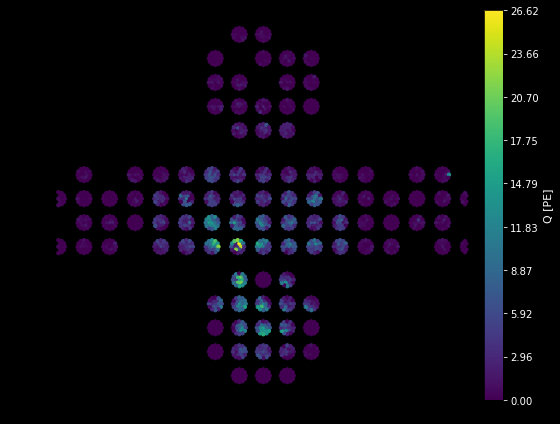

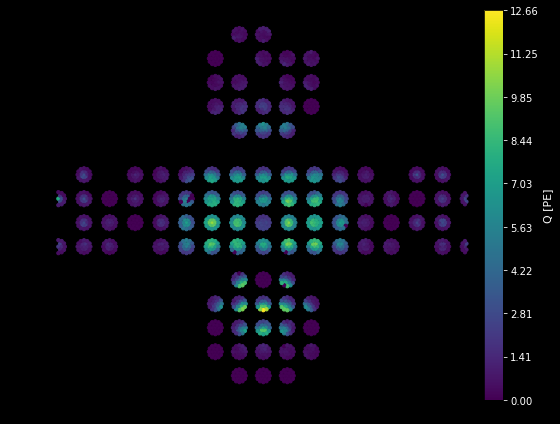

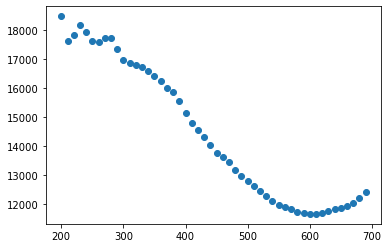

In [60]:
evt_id = 82     
make_event_display(evt_id)
loss_surface_scan(evt_id)